In [3]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from model import Repository, File, Function, Version, BaseModel
import os
from typing import Any, Dict, Type, List
import pickle
import re
from collections import defaultdict
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
def read_json_lines(cls: Type[BaseModel]) -> Dict[int, Dict[str, Any]]:
    instances = {}
    for i in range(cls.N_FILES):
        filename = f"{cls.DATA_DIRECTORY}/{cls.FILENAME_PREFIX}{i}.json"
        if not os.path.exists(filename):
            continue
        with open(filename, "r") as f:
            lines = f.readlines()
        for line in lines:
            instance = cls.from_dict(json.loads(line))
            instances[instance.id] = instance
    return instances


repositories = read_json_lines(Repository)
files = read_json_lines(File)
functions = read_json_lines(Function)
versions = read_json_lines(Version)

In [6]:
pattern0 = re.compile(r'\n( )+\n')
pattern1 = re.compile(r'(\n){2,}')

def clean_code(code: str) -> str:
    lines = [line.split("#")[0].rstrip() for line in code.split("\n")]
    while all([line.startswith("    ") for line in lines]):
        lines = [line[4:] for line in lines]
    code = "\n".join(lines)
    code = re.sub(pattern0, "\n", code)
    code = re.sub(pattern1, "\n", code, count=1)
    return code

def get_body_begin(code: str) -> int:
    index = code.find(":\n")
    return index + 2


In [7]:
DATA_PICKLE_PATH = "data.pkl"

if os.path.exists(DATA_PICKLE_PATH):
    with open(DATA_PICKLE_PATH, "rb") as f:
        df = pickle.load(f)
else:
    columns = [
        "id", "code", "docstring", "code_updated", "docstring_updated", "code_similarity", "docstring_similarity", "last_version", "body_begin",
        "function_name", "filename", 
        "repo_name", "size", "open_issues", "watchers", "contributors", "forks", "contributions", "stars"
    ]
    df = pd.DataFrame(columns=columns)

    chunk_size = 10_000
    chunk = []

    for y, version in enumerate(versions.values()):
        function = functions[version.function]
        file = files[function.file]
        repo = repositories[file.repo]

        code = clean_code(version.code)
        body_begin = get_body_begin(code)

        chunk.append({
            "id": version.id,
            "code": code,
            "docstring": version.docstring,
            "code_updated": version.code_updated,
            "docstring_updated": version.docstring_updated,
            "code_similarity": version.code_similarity,
            "docstring_similarity": version.docstring_similarity,
            "last_version": version.last_version,
            "body_begin": body_begin,
            "function_name": function.name,
            "filename": file.path,
            "repo_name": repo.full_name,
            "size": repo.size,
            "open_issues": repo.open_issues,
            "watchers": repo.watchers,
            "contributors": repo.contributors,
            "forks": repo.forks,
            "contributions": repo.contributions,
            "stars": repo.stars
        })
        if (y + 1) % chunk_size == 0:
            df = pd.concat([df, pd.DataFrame(chunk, columns=columns)], ignore_index=True)
            chunk = []

    if chunk:
        df = pd.concat([df, pd.DataFrame(chunk, columns=columns)], ignore_index=True)

    with open(DATA_PICKLE_PATH, "wb") as f:
        pickle.dump(df, f)

print(df.shape)
df.head()

(10731959, 19)


,id,code,docstring,code_updated,docstring_updated,code_similarity,docstring_similarity,last_version,body_begin,function_name,filename,repo_name,size,open_issues,watchers,contributors,forks,contributions,stars
0,281788312471571271411713139082107975232,def main():\n parser = optparse.OptionParse...,Reads through README.md for question/answer pa...,False,True,1.000000,1.000000,333488746175890530381688242698456090929,12,main,scripts/random_question.py,bregman-arie/devops-exercises,4473,27,64593,30,14241,206,64593
1,239386945494245576266821734540139996096,def test_organize_commands():\n commands = ...,Ensures that the function removes duplicates a...,None,None,NaN,NaN,None,30,test_organize_commands,tests/test_corrector.py,nvbn/thefuck,4043,333,83486,30,3405,1430,83486
2,168985134380115035233731450556622184000,"def decode_with_timestamps(self, tokens) -> st...",Timestamp tokens are above the special tokens'...,True,True,0.426573,0.994152,145153054208182570237933174687295647075,49,decode_with_timestamps,whisper/tokenizer.py,openai/whisper,12733,64,63500,30,7368,100,63500
3,27903987367852635492599971673566981504,def _get_user_dir_path(self):\n xdg...,returns Path object representing the user conf...,True,True,0.908480,0.982456,260170128862352951651779973074505846437,34,_get_user_dir_path,thefuck/conf.py,nvbn/thefuck,4043,333,83486,30,3405,1430,83486
4,51519825779335821027449849688061713984,def organize_commands(corrected_commands):\n ...,Yields sorted commands without duplicates.\n\n...,True,False,0.991648,1.000000,144990813432895563301648095845037702504,43,organize_commands,thefuck/corrector.py,nvbn/thefuck,4043,333,83486,30,3405,1430,83486


In [8]:
N_SAMPLES = 100_000
sampled_df = df.sample(n=min(N_SAMPLES, df.shape[0]), random_state=42)

# repository statistics
stars = sampled_df.groupby("repo_name")["stars"].first().reset_index()["stars"].to_frame()
watchers = sampled_df.groupby("repo_name")["watchers"].first().reset_index()["watchers"].to_frame()
forks = sampled_df.groupby("repo_name")["forks"].first().reset_index()["forks"].to_frame()
contributors = sampled_df.groupby("repo_name")["contributors"].first().reset_index()["contributors"].to_frame()
open_issues = sampled_df.groupby("repo_name")["open_issues"].first().reset_index()["open_issues"].to_frame()
contributions = sampled_df.groupby("repo_name")["contributions"].first().reset_index()["contributions"].to_frame()
sizes = sampled_df.groupby("repo_name")["size"].first().reset_index()["size"].to_frame().rename(columns={"size": "sizes"})
functions = sampled_df.groupby("repo_name")["function_name"].nunique().reset_index()["function_name"].to_frame().rename(columns={"function_name": "functions"})
versions = sampled_df.groupby("repo_name")["id"].nunique().reset_index()["id"].to_frame().rename(columns={"id": "versions"})
repository_statistics = {
    "stars": (stars, "stars"),
    "watchers": (watchers, "watchers"),
    "forks": (forks, "forks"),
    "contributors": (contributors, "contributors"),
    "open_issues": (open_issues, "open_issues"),
    "contributions": (contributions, "contributions"),
    "sizes": (sizes, "sizes"),
    "functions": (functions, "functions"),
    "versions": (versions, "versions")
}

# version statistics
code_lengths = sampled_df["code"].apply(len).to_frame().rename(columns={"code": "code_lengths"})
docstring_lengths = sampled_df["docstring"].apply(len).to_frame().rename(columns={"docstring": "docstring_lengths"})
code_similarity = sampled_df["code_similarity"].to_frame()
docstring_similarity = sampled_df["docstring_similarity"].to_frame()
version_statistics = {
    "code_lengths": (code_lengths, "code_lengths"),
    "docstring_lengths": (docstring_lengths, "docstring_lengths"),
    "code_similarity": (code_similarity, "code_similarities"),
    "docstring_similarity": (docstring_similarity, "docstring_similarities")
}

In [15]:
len(df.groupby("repo_name"))

895

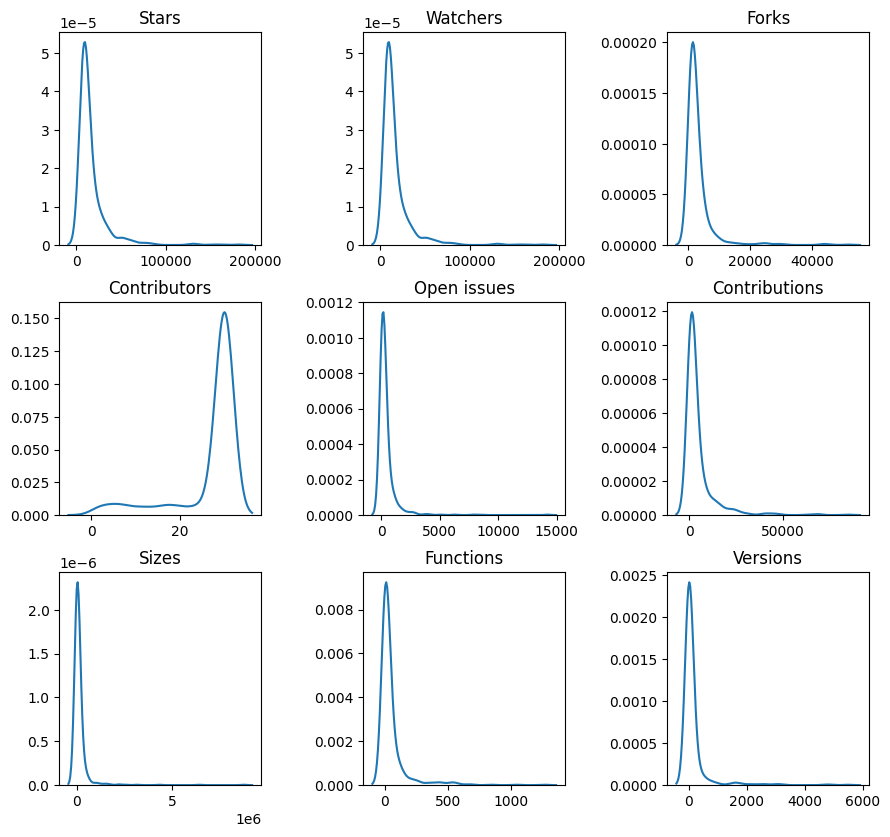

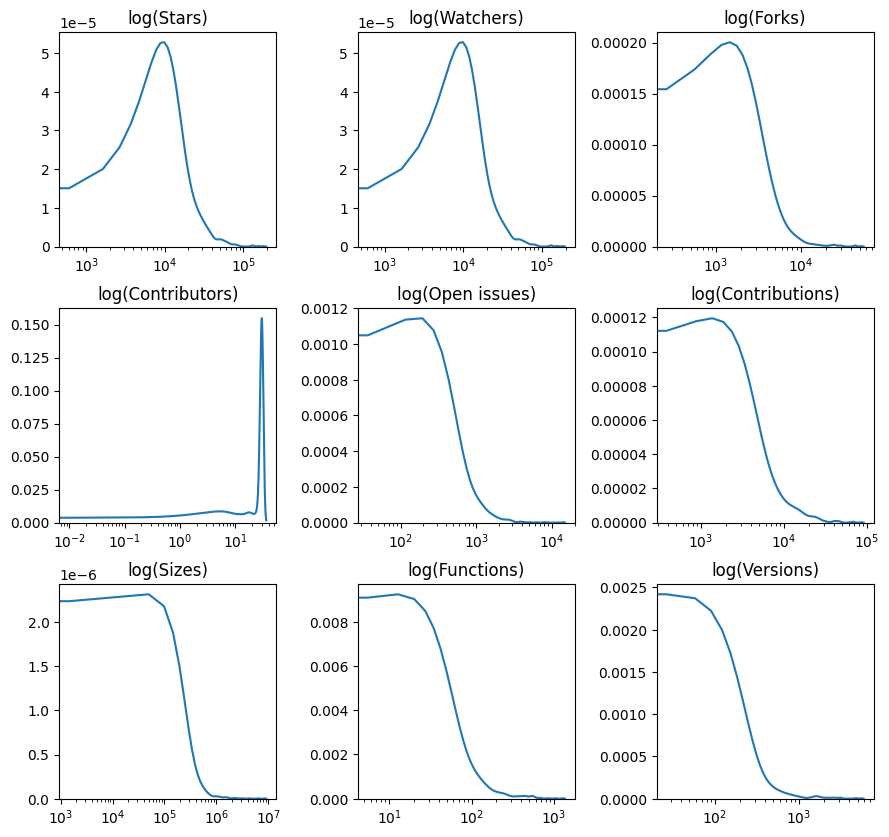

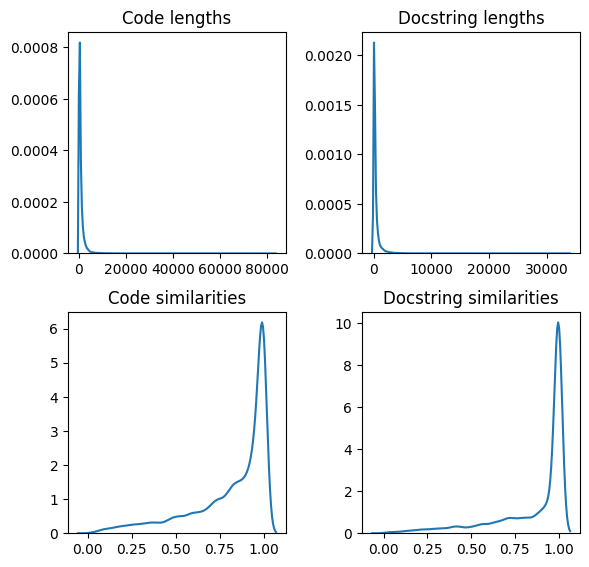

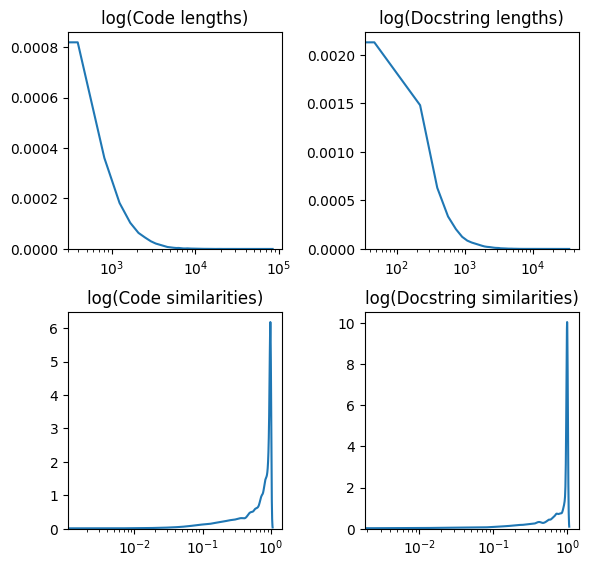

In [12]:
for statistics, title, width, height in (
    (repository_statistics, "Repositories", 3, 3), 
    (version_statistics, "Versions", 2, 2)
):
    for do_log in (False, True):
        fig, axes = plt.subplots(width, height, figsize=(3 * height, 3 * width))

        for y, x in ((y, x) for y in range(width) for x in range(height)):
            key = list(statistics.keys())[y * height + x]
            data, name = statistics[key]
            ax = axes[y, x]
            sns.kdeplot(data, ax=ax, legend=False)
            ax.set_ylabel("")
            if do_log:
                ax.set_xscale("log")
                ax.set_title(f"log({name.capitalize().replace('_', ' ')})")
            else:
                ax.set_title(name.capitalize().replace('_', ' '))

        plt.tight_layout()
        # plt.suptitle(title, fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()

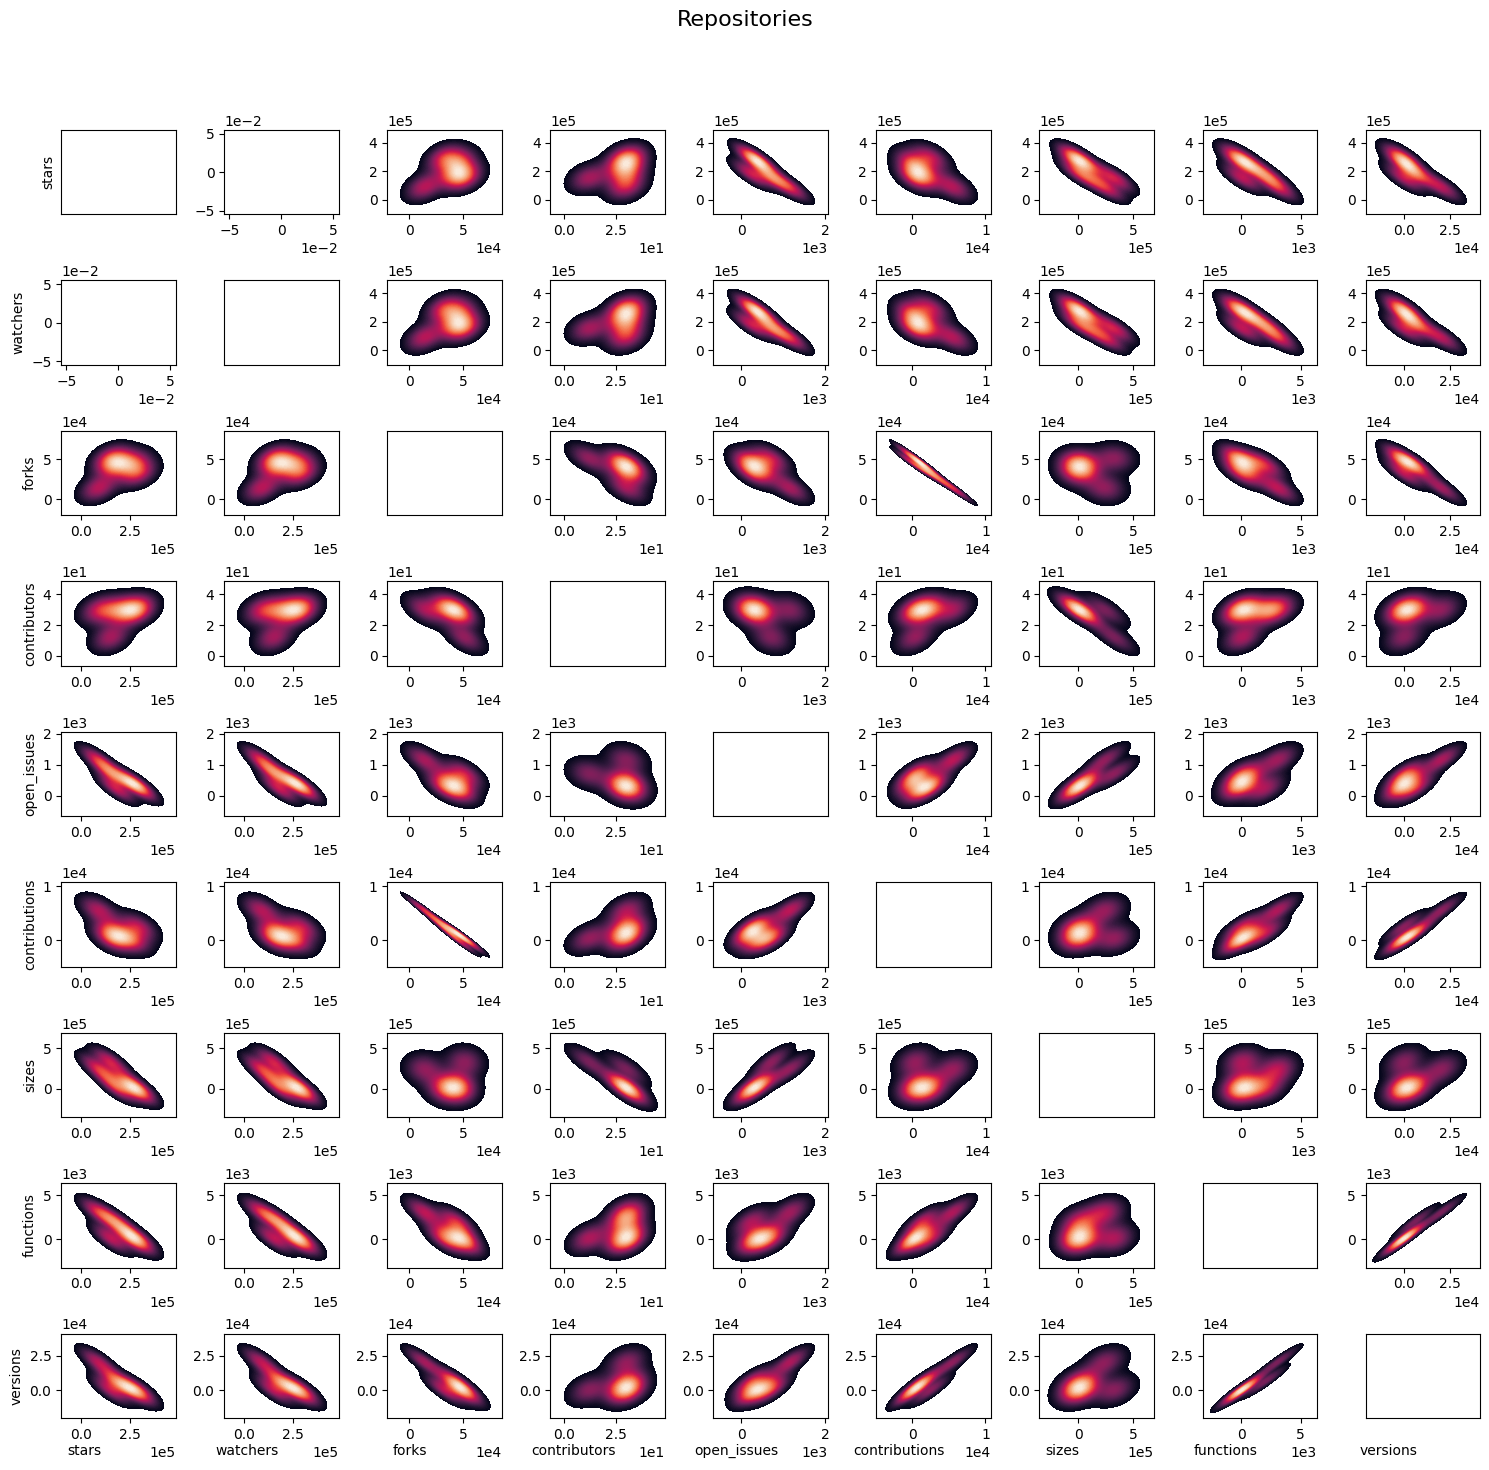

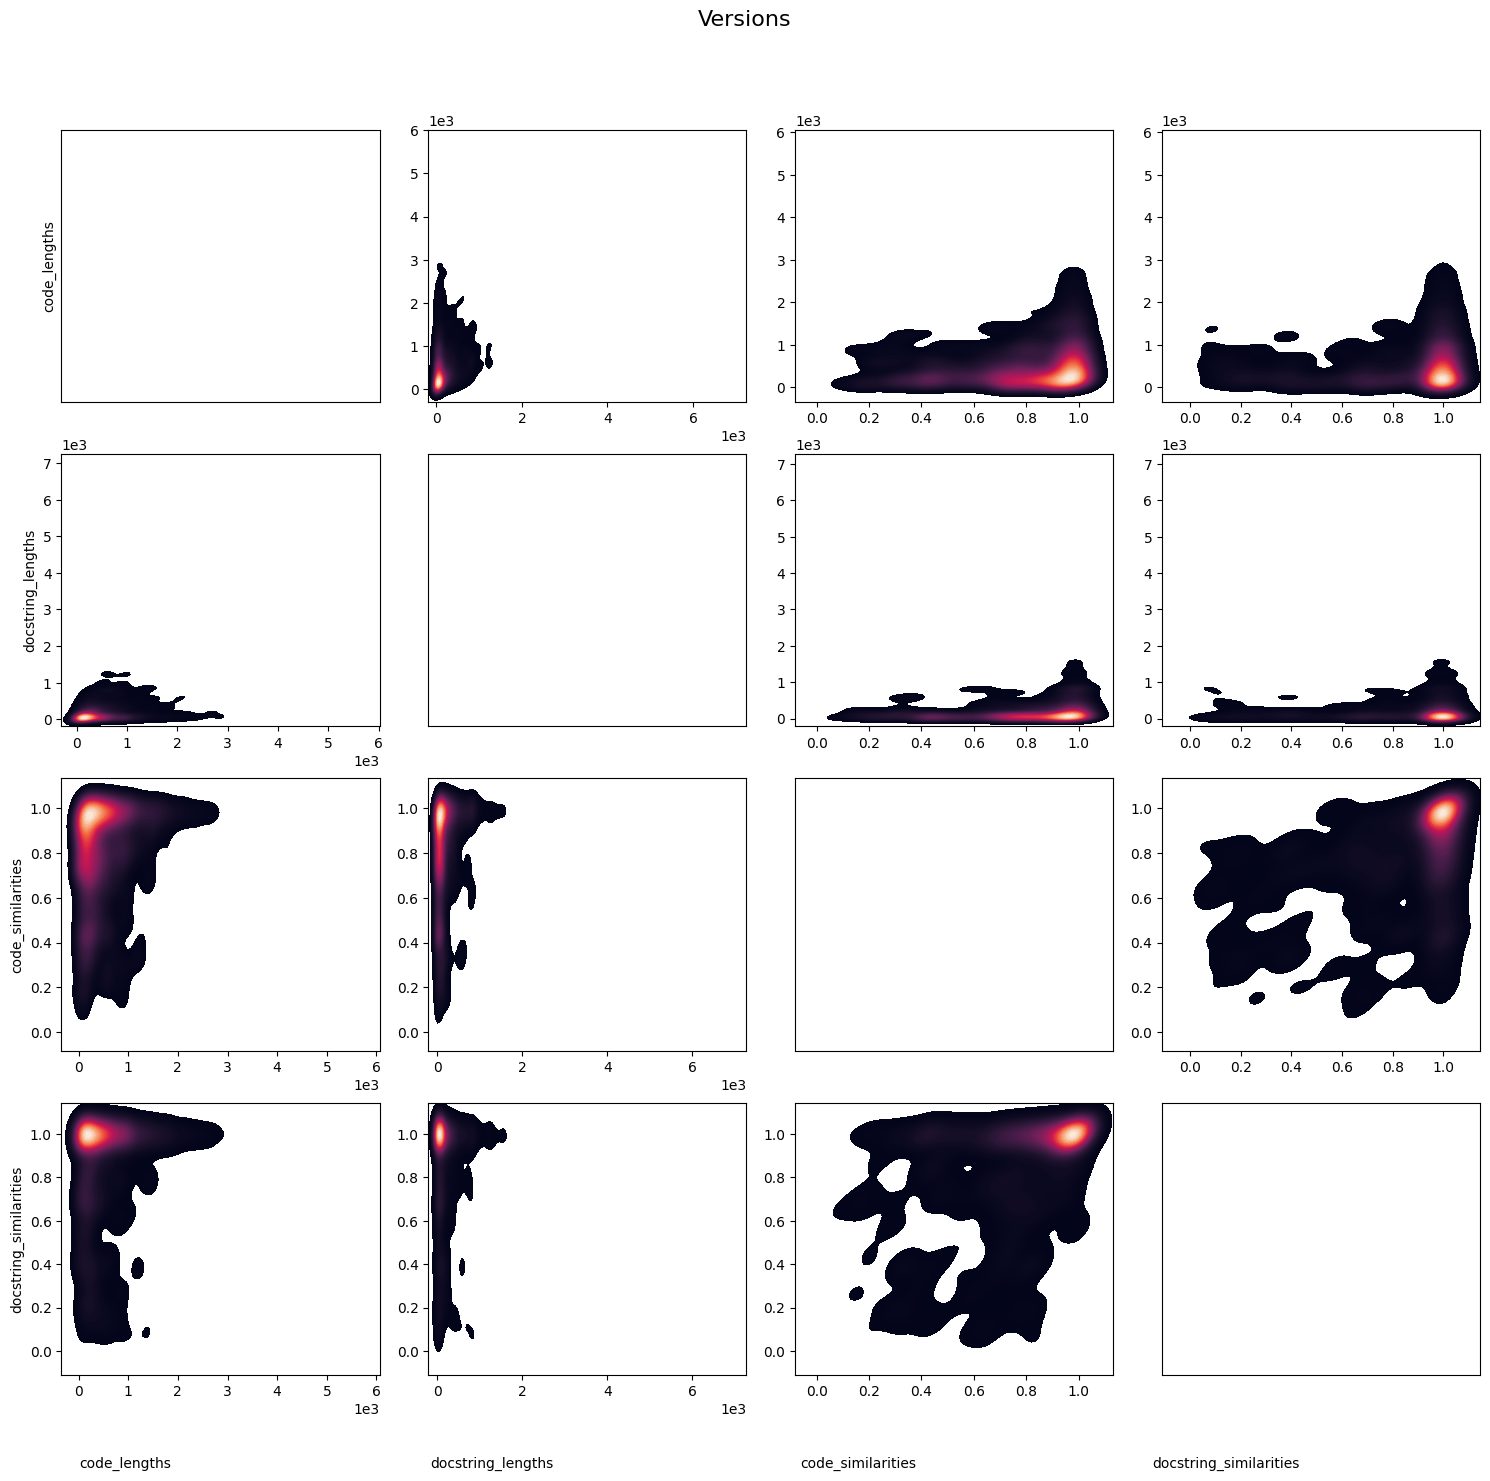

In [7]:
for statistics, title, width, height in (
    (repository_statistics, "Repositories", 3, 3), 
    (version_statistics, "Versions", 2, 2)
):
    fig, axes = plt.subplots(width * height, width * height, figsize=(15, 15))

    for y in range(len(statistics.keys())):
        for x in range(len(statistics.keys())):
            key1 = list(statistics.keys())[y]
            key2 = list(statistics.keys())[x]
            data1, name1 = statistics[key1]
            data2, name2 = statistics[key2]
            ax = axes[y, x]
            
            try:
                if y == x:
                    sns.kdeplot(x=[], y=[], ax=ax, legend=False, fill=True, warn_singular=False)
                else:
                    sns.kdeplot(x=data2[key2], y=data1[key1], ax=ax, cmap="rocket", fill=True, legend=False, warn_singular=False, levels=100)
            except ValueError:
                continue

            if y == (width * width) - 1:
                ax.set_xlabel(name2)
            else:
                ax.set_xlabel("")
            if x == 0:
                ax.set_ylabel(name1)
            else:
                ax.set_ylabel("")
            ax.xaxis.set_label_coords(0.2, -0.3)
            if x == y:
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [8]:
def get_uniform_sample_overall_n(df, column, overall_n):
    # Calculate the number of unique values in the specified column
    unique_values = df[column].nunique()
    
    # Determine the initial number of samples per group
    n_per_group = overall_n // unique_values
    
    # Group by the specified column
    groups = df.groupby(column)
    
    # Track samples and remaining count
    samples = []
    remaining_samples = overall_n
    group_sizes = defaultdict(int)
    
    # Sample from each group initially
    for name, group in groups:
        group_size = min(n_per_group, len(group))
        group_samples = group.sample(n=group_size, random_state=42)
        samples.append(group_samples)
        remaining_samples -= group_size
        group_sizes[name] = len(group_samples)
    
    # Collect all sampled groups together
    result = pd.concat(samples)
    
    # If we need more samples to meet overall_n, redistribute the remaining samples
    if remaining_samples > 0:
        remaining_groups = {name: group for name, group in groups if len(group) > group_sizes[name]}
        
        while remaining_samples > 0 and remaining_groups:
            for name, group in remaining_groups.items():
                available_samples = len(group) - group_sizes[name]
                if available_samples > 0:
                    sample_size = min(available_samples, 1)  # Take one sample at a time from remaining groups
                    additional_sample = group.iloc[group_sizes[name]:group_sizes[name] + sample_size]
                    result = pd.concat([result, additional_sample])
                    group_sizes[name] += sample_size
                    remaining_samples -= sample_size
                    if remaining_samples == 0:
                        break
            remaining_groups = {name: group for name, group in remaining_groups.items() if len(group) > group_sizes[name]}
    
    # If there are still remaining samples needed, sample randomly from the existing result with replacement
    if remaining_samples > 0:
        additional_samples = df.sample(n=remaining_samples, random_state=42, replace=True)
        result = pd.concat([result, additional_samples])
    
    # Ensure the final result has exactly overall_n samples
    result = result.sample(n=overall_n, random_state=42, replace=False)
    
    return result

In [9]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.dropna()
    return df

In [33]:
N_SPECIAL_REPOS: int = 1
N_TRAIN_TEST_SAMPLES: int = 100_000
TRAIN_TEST_SPLIT: float = 0.8

SPECIAL_REPO_PICKLE_PATH: str = "special_repos.pkl"
TRAIN_PICKLE_PATH: str = "train.pkl"
TEST_PICKLE_PATH: str = "test.pkl"

if os.path.exists(SPECIAL_REPO_PICKLE_PATH):
    with open(SPECIAL_REPO_PICKLE_PATH, "rb") as f:
        special_repos_df = pickle.load(f)
    with open(TRAIN_PICKLE_PATH, "rb") as f:
        train_df = pickle.load(f)
    with open(TEST_PICKLE_PATH, "rb") as f:
        test_df = pickle.load(f)
else:
    cleaned_df = clean_df(df)

    sampled_repos = cleaned_df['repo_name'].sample(n=N_SPECIAL_REPOS, random_state=42).values
    special_repos_df = cleaned_df[cleaned_df['repo_name'].isin(sampled_repos)]
    print(special_repos_df["repo_name"].unique())

    train_test_df = cleaned_df[~cleaned_df['repo_name'].isin(sampled_repos)]
    train_test_df = get_uniform_sample_overall_n(train_test_df, "repo_name", min(N_TRAIN_TEST_SAMPLES, train_test_df.shape[0]))

    train_df, test_df = train_test_split(train_test_df, train_size=1 - TRAIN_TEST_SPLIT, random_state=42)

    train_df = train_test_df.sample(frac=TRAIN_TEST_SPLIT, random_state=42)
    test_df = train_test_df.drop(train_df.index)

    with open(SPECIAL_REPO_PICKLE_PATH, "wb") as f:
        pickle.dump(special_repos_df, f)
    with open(TRAIN_PICKLE_PATH, "wb") as f:
        pickle.dump(train_df, f)
    with open(TEST_PICKLE_PATH, "wb") as f:
        pickle.dump(test_df, f)

print(special_repos_df.shape)
print(train_df.shape)
print(test_df.shape)


['TheAlgorithms/Python']
(3513, 19)
(11810, 19)
(2072, 19)


In [30]:
MAX_TRIES: int = 16

def permutation(n: int) -> np.ndarray:
    tries = 0
    while tries < MAX_TRIES:
        np.random.seed(42 + hash(tries))
        perm = np.random.permutation(n)
        if np.all(perm != np.arange(n)):
            return perm
        tries += 1
    print("Max tries exceeded")
    return perm

In [32]:
special_repos_data: List[Dict[str, Any]] = []
train_data: List[Dict[str, Any]] = []
test_data: List[Dict[str, Any]] = []

PREFIX_TOKEN: str = '<|fim_prefix|>'
SUFFIX_TOKEN: str = '<|fim_suffix|>'
MIDDLE_TOKEN: str = '<|fim_middle|>'
FILE_SEPARATOR: str = '<|file_separator|>'
INDENT: str = '    '

def extract_sample(row: pd.Series) -> Dict[str, Any]:
    code = row["code"]
    docstring = row["docstring"]
    body_begin = row["body_begin"]
    
    header = code[:body_begin]
    body = code[body_begin:]

    return {
        "e": f'{PREFIX_TOKEN}{header}\n{INDENT}"""{SUFFIX_TOKEN}"""\n{INDENT}{body}{MIDDLE_TOKEN}{docstring}{FILE_SEPARATOR}',
        "l": row["label"],
        "c": code,
        "d": docstring
    }

for df_, name, create_negatives in (
    # (special_repos_df, "special_repos", True),
    (train_df, "train", False),
    (test_df, "test", True)
):
    df_["label"] = True
    if create_negatives:
        negatives_df = df_.copy()
        negatives_df["docstring"] = df_["docstring"].values[permutation(df_.shape[0])]
        negatives_df["label"] = False
        df_ = pd.concat([df_, negatives_df], ignore_index=True)
    data = list(df_.apply(extract_sample, axis=1).values)
    with open(f"{name}_data.json", "w") as f:
        json.dump(data, f)
    

/tmp/ipykernel_429791/3827897445.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["label"] = True
